In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

# setting plot fonts
fontdict = {'family': 'Times New Roman', 'size': 20}

In [25]:
def cross_point(y, th):
    """
    function for calculating the cross point of a predefined threshold with the fluorescence signal curves
    """
    x = 0
    dy = th - y
    for i in range(len(y) - 1):
        if np.dot(dy[i], dy[i+1]) == 0:
            if dy[i] == 0:
                x = i
            if dy[i+1] == 0:
                x = i + 1
        elif np.dot(dy[i], dy[i+1]) < 0:
            x = i + dy[i] / (y[i+1] - y[i])
        else:
            pass
    return x

In [49]:
# P0 is the primer copy number
# T0 is the template copy number
# k1 is the forward kinetic parameter
# k2 is the backward kinetic parameter
# sigma is the efficiency variant parameter, with default value 1e-8, disrupt value 1e-5
# gamma is the kinetic deviation parameter, default value 1e-5, disrupt value 5e-3

P0, k1, k2, sigma, gamma = 1e2, 1e-2, 0, 1e-5, 1e-5
collect_T = []
collect_P = []

for T0 in 0.1/2**np.arange(30):
    for r in range(100):
        # 100 repetities for each initial concentration
        T = [T0]
        T_fl = [T0]
        P = [T0]
        
        for n in range(1, 40):
            T_pre = T[n-1]
            P_pre = P[n-1]
            T_after = (1 + (gamma * np.random.randn() + k1) * P_pre - k2 * T_pre) * T_pre + sigma * np.random.randn() # follow a two-state kinetic model
            if T_after < 0:
                T_after = T_pre
            P_after = T0 + P0 - T_after # exhausted primers 
            T_signal = T_after + 3 * np.random.randn()
            T.append(T_after)
            P.append(P_after)
            T_fl.append(T_signal)
            
        collect_T = collect_T + T_fl.copy()
        collect_P = collect_P + P.copy()

In [50]:
signal = np.array(collect_T).reshape(-1, 40)

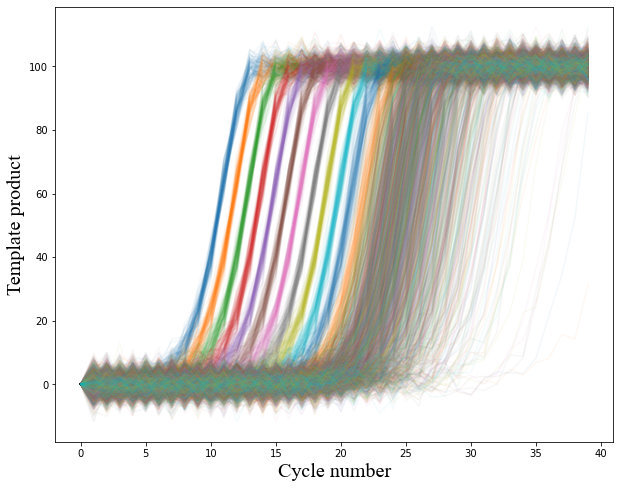

In [51]:
plt.figure(figsize=(10, 8))
colors=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
for i in range(30):
    for j in range(i*100, i*100+99):
        plt.plot(np.arange(40), signal[j, :], alpha=0.05, color=colors[i%10])
#for i in range(signal.shape[0]):
#    plt.plot(np.arange(40), signal[i, :], alpha=0.01, color=colors[0])
plt.xlabel(r'Cycle number', fontdict=fontdict)
plt.ylabel(r'Template product', fontdict=fontdict)
plt.savefig('sim_noise_efficiency.tif', dpi=300)

In [52]:
th = 5   
cross = []
for i in range(30):
    temp = []
    for j in range(i*100, i*100+100):
        point = cross_point(signal[j, :], th)
        temp.append(point)
    cross.append(np.array(temp))

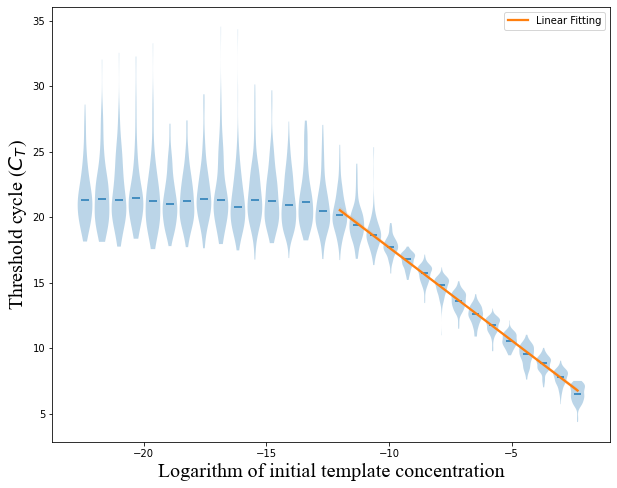

In [54]:
plt.figure(figsize=(10, 8))
pos = [np.log(0.1/2**i) for i in range(30)]
violin_param = plt.violinplot(cross, positions=pos, showextrema=False, showmedians=True, widths=0.6)
ms = np.median(np.array(cross), axis=1)
sns.regplot(x=np.log(0.1 / 2 ** np.arange(15)), y=ms[:15], scatter=False, label='Linear Fitting')
plt.xlabel(r'Logarithm of initial template concentration', fontdict=fontdict)
plt.ylabel(r'Threshold cycle ($C_T$)', fontdict=fontdict)
plt.legend()
plt.savefig('threshold_violin_efficiency.tif', dpi=300)